<h1><center>A Tutorial for the Bell Energy Balance Model (Bell_EBM)</center></h1>

## Author: Taylor James Bell (McGill University)
#### Last Modified: 2018-11-30

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const

import Bell_EBM as ebm

<center>
    <h1>First, let's setup a planet, star, and system</h1>
    <h3>We'll use the WASP-12b system and include the effects of H<sub>2</sub> dissociation (Bell & Cowan 2018)</h3>
</center>

In [2]:
# WASP-12b
# Radius and mass are in Jupiter units
# Orbital Period is in units of days
# Semi-major axis is in AU
# Wind speed is in m/s
# All angles are in degrees
planet = ebm.Planet('bell2018', rad=1.900, mass=1.470,
                    Porb=1.09142030, a=0.02340, inc=83.37, vWind=5e3)

# WASP-12
# Radius and mass are in solar units
# Temperatures are always in K
star = ebm.Star(teff=6300., rad=1.59, mass=1.20)

# Load the star and planet into a system
system = ebm.System(star, planet)

## Let's show the star-planet system

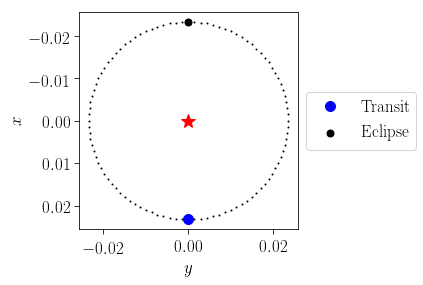

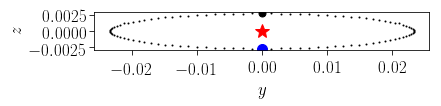

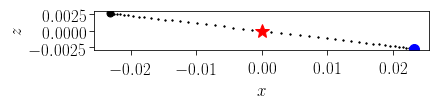

In [3]:
fig = planet.orbit.plot_orbit()
plt.show()

## Now, let's model the planet's atmoshere

In [4]:
# Run initial burn-in - try guessing the median equilibrium temperature to begin with
Teq = np.median(system.get_teq(np.linspace(0,system.planet.Porb,1000, endpoint=False)))
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = system.planet.Porb*20.
dt = system.planet.Porb/10.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

# Run a higher time resolution burn-in to clean up any remaining mess
T0 = maps[-1]
t0 = times[-1]
t1 = t0+system.planet.Porb*20.
dt = system.planet.Porb/100.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

## Then we can visualize the planet's temperature and H<sub>2</sub> dissociation map
#### Even with only moderate winds, there is a strong hotspot offset due to the effects of H<sub>2</sub> dissociation/recombination

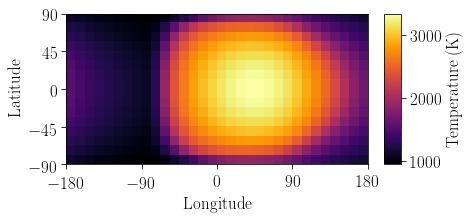

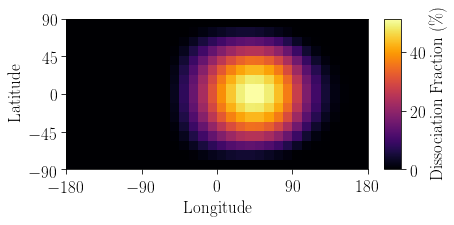

In [5]:
fig = system.planet.plot_map()
plt.show()

fig = system.planet.plot_H2_dissociation()
plt.show()

## Finally, we can look at the orbital phase curve

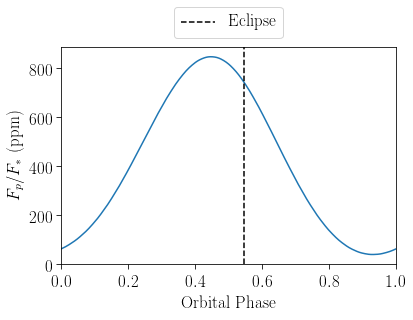

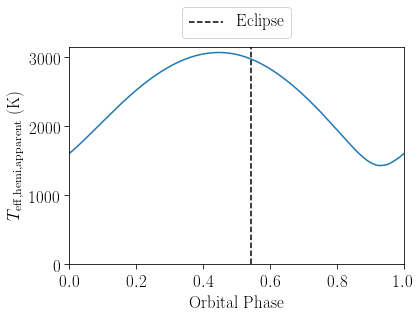

In [6]:
# Plot the lightcurves - by default it will use one planetary orbit
fig = system.plot_lightcurve()
plt.show()

# Plot the temperature curves
fig = system.plot_tempcurve()
plt.show()

<br/><br/><br/><br/><br/>
<h1><center>Now let's look at an eccentric rocky planet in a 3:2 spin-orbit resonance</center></h1>

In [7]:
# We can also specify a rotation rate for the planet: we'll say it somehow isn't
# tidally locked yet. We also don't have to specify the planet's orbital period:
# it will be calculated using Kepler's equations
planet = ebm.Planet('rock', rad=const.R_earth.value/const.R_jup.value,
                    mass=const.M_earth.value/const.M_jup.value,
                    a=0.05, e=0.4, argp=45.)

# The default values are the sun's values already
star = ebm.Star()

# Load everything into the system: this is when the orbital period is calculated
system = ebm.System(star, planet)

# Now that we know the orbital period, we can set the planet's rotation period
system.planet.set_Prot(system.planet.Porb*(2./3.))

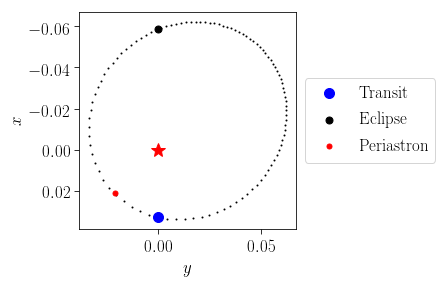

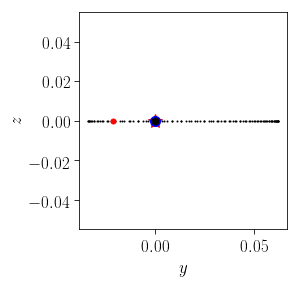

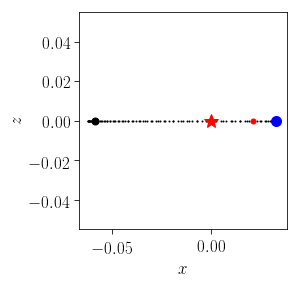

In [8]:
# The plotted dots have equal spacing in time, so the get scruntched up near apastron
fig = planet.orbit.plot_orbit()
plt.show()

In [9]:
# Run initial burn-in - try guessing the median irradiation temperature to begin with
Teq = np.median(system.get_teq(np.linspace(0.,system.planet.Porb,1000, endpoint=False)))
T0 = Teq*np.ones_like(system.planet.map.values)
t0 = 0.
t1 = system.planet.Porb*20.
dt = system.planet.Porb/10.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

# Run a higher time resolution burn-in to clean up any remaining mess
T0 = maps[-1]
t0 = times[-1]
t1 = t0+system.planet.Porb*20.
dt = system.planet.Porb/100.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

### Because this is an eccentric planet and it isn't synchronously rotating, it's map isn't constant with time. <br/> As a result, we need to grab the map and time stamps for one orbit to do our plotting

In [10]:
T0 = maps[-1]
t0 = times[-1]
t1 = t0+system.planet.Porb
dt = system.planet.Porb/1000.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

## Let's show the map during periastron
#### For planet's which are not synchronously rotating, the longitude of zero in all plots refers to the sub-stellar point. This requires that we pass in the time of the map though, so it can rotate it as necessary

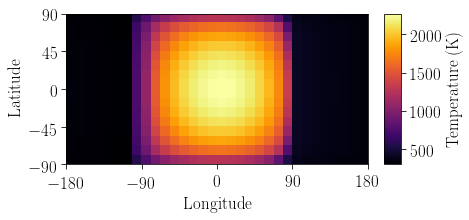

In [11]:
phases = system.get_phase(times)
phasePeri = system.get_phase_periastron()
indexPeri = np.argmin(np.abs(phases-phasePeri))

fig = system.planet.plot_map(maps[indexPeri], times[indexPeri])
plt.show()

## This time, let's look at the lightcurve at the Spitzer/IRAC 4.5 micron band

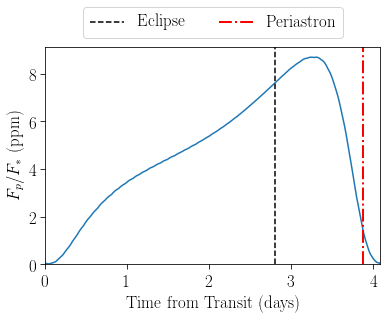

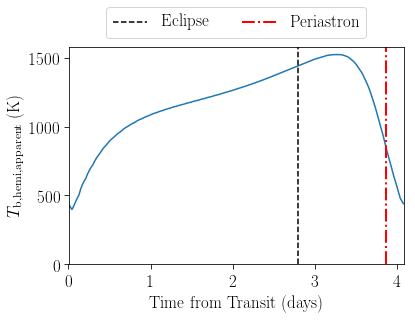

In [12]:
# Plot the lightcurves
fig = system.plot_lightcurve(times, maps, bolo=False, wav=4.5e-6)
plt.show()

# Plot the temperature curves
fig = system.plot_tempcurve(times, maps, bolo=False, wav=4.5e-6)
plt.show()

### It might seem odd that the coldest temperature on the plot above is near periastron when the planet is receiving the most flux, but this is because we are looking at the planet's cold nightside at that point in time

<br/><br/><br/><br/><br/>
# Now let's try to model the Earth (a pretty challenging task...) to demonstrate the flexibility, strengths, and weaknesses of this EBM.

#### We'll need to make some simplifying assumptions. We'll pretend that we only probe the atmosphere (pretending the atmosphere is opaque) and assume the atmosphere is made of pure N2. Feel free to instead model the Earth as pure rock or water, and see how the results change!

#### If you have healpy installed on your computer, you can also use healpix maps by setting "useHealpix=True" when initializing the planet. If the following cell fails for you, either install healpy or remove "useHealpix=True".

In [13]:
# The Earth's atmosphere is mostly N2, so we'll change the heat capacity
# of the gas from H2 (the default) to N2
cp_N2 = 1.039e3 # J/(kg K)

# We'll pretend the whole atmosphere absorbs and radiates
P0 = const.atm.value

a = 1. # AU

Rp = const.R_earth.value/const.R_jup.value # R_jup

Mp = const.M_earth.value/const.M_jup.value # M_jup

Prot = 1. # days

albedo = 0.30

e = 0.0167

obliquity = 23.5 # degrees

# We'll assume that the Earth transits during the northern hemisphere's summer solstice
argp = -90
t0 = 0

planet = ebm.Planet('gas', rad=Rp, mass=Mp, Prot=Prot, a=a, e=e, obliq=obliquity,
                    argp=argp, t0=t0, cp=cp_N2, mlDepth=P0, albedo=albedo,
                    useHealpix=True)

# The default values are the sun's values already
star = ebm.Star()

# Load everything into the system
system = ebm.System(star, planet)

#### Given the extreme difference between the spin and orbital periods, burning in this planet is a little trickier and takes longer

In [14]:
# Run initial burn-in - try guessing the median irradiation temperature to begin with
T0 = system.get_teq()*np.ones_like(system.planet.map.values)
t0 = planet.t0
t1 = system.planet.Prot*20.
dt = system.planet.Prot/10.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

# Run for two full-orbits to work out seasonal variations
T0 = maps[-1]
t0 = times[-1]
# Run for a weird length of time to get the production run to start at a phase close to 0
t1 = t0+system.planet.Porb*2-system.planet.Prot*21.
dt = system.planet.Prot/2
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

# Run one day at high-rez to get good temperatures around the planet
T0 = maps[-1]
t0 = times[-1]
t1 = t0+system.planet.Prot
dt = system.planet.Prot/100
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

#### Run a production run

In [15]:
T0 = maps[-1]
t0 = times[-1]
t1 = t0+system.planet.Porb
# We'll use a small time step to make sure we're doing a good job
dt = system.planet.Prot/10.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)

# Then we'll cut down on the number of points, since our full-orbit phasecurves
# don't need that high of a time resolution. Just daily outputs are fine
times = times[::10]
maps = maps[::10]

## Let's get the lightcurves ignoring and accounting for reflected light to demonstrate the difference at blue wavelengths

In [16]:
lc_withReflection = system.lightcurve(times, maps, bolo=False, wav=0.5e-6)
lc_ignoringReflection = system.lightcurve(times, maps, bolo=False,
                                          wav=0.5e-6, allowReflect=False)

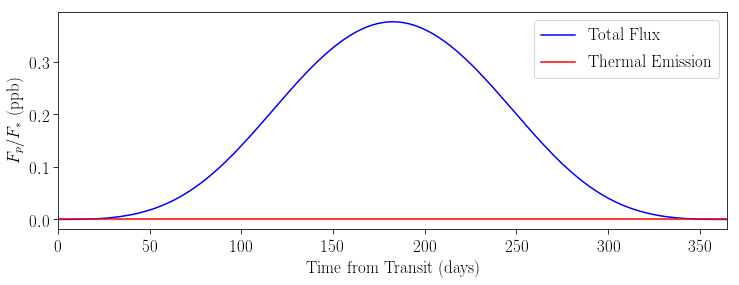

In [17]:
x = times.flatten()
x = (x-planet.Porb*int(np.median(x/planet.Porb)))

fig = plt.figure(figsize=(12,4))
plt.plot(x, lc_withReflection*1e9, c='b', label=r'$\rm Total~Flux$')
plt.plot(x, lc_ignoringReflection*1e9, c='r', label=r'$\rm Thermal~Emission$')
plt.ylabel(r'$F_p/F_* \rm ~(ppb)$')
plt.xlabel(r'$\rm Time~from~Transit~(days)$')
plt.xlim(0, 365)
plt.legend(loc='best')
plt.show()
plt.close(fig)

#### We're seeing here that at short wavelengths nearly all of the flux comes from reflected light, and the amount of light we see varies due to the Earth going through different phases (like the Moon does from our perspective). The blue curve just ends up being the Lambertian phase function

## This time, let's look at the peak in Earth's thermal emission (~10 microns) where reflected light shouldn't matter near as much

In [18]:
lc_withReflection = system.lightcurve(times, maps, bolo=False, wav=10e-6)
lc_ignoringReflection = system.lightcurve(times, maps, bolo=False,
                                          wav=10e-6, allowReflect=False)

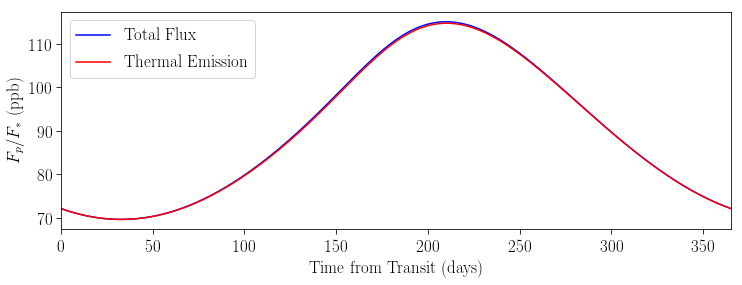

In [19]:
x = times.flatten()
x = (x-planet.Porb*int(np.median(x/planet.Porb)))

fig = plt.figure(figsize=(12,4))
plt.plot(x, lc_withReflection*1e9, c='b', label=r'$\rm Total~Flux$')
plt.plot(x, lc_ignoringReflection*1e9, c='r', label=r'$\rm Thermal~Emission$')
plt.ylabel(r'$F_p/F_* \rm ~(ppb)$')
plt.xlabel(r'$\rm Time~from~Transit~(days)$')
plt.xlim(0, 365)
plt.legend(loc='best')
plt.show()
plt.close(fig)

#### We see that there is a significant offset in the peak of the phasecurve due to the rapid rotation of the planet, and we also see that thermal emission indeed dominates

<br/>

## While this EBM is quite flexible, it is by no means perfect, and you should evaluate your findings with caution and scepticism (as with all things in science).

#### Let's show the planet's map at the time of the last timestep in the production run (which is during the Northern Hemisphere's Summer Solstice)

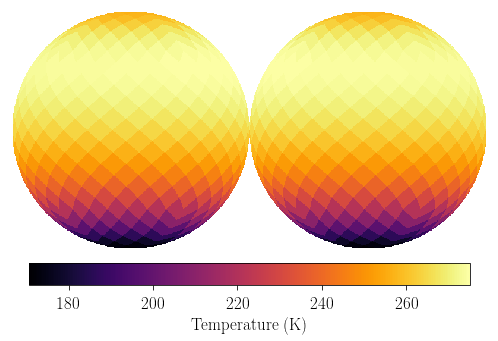

In [20]:
fig = system.planet.plot_map()
plt.show()

#### As you can see, the map doesn't appear to make a lot of sense - the south pole is far too cold (-100°C), the tropics are too cold, and the maximum temperature is only ~6°C. This is because we haven't taken into account many important features like spatially varying albedo, the contribution of flux from the surface (the Earth's atmosphere is not opaque), latent heat, any north-south heat transport (e.g. Hadley circulation), ocean currents, greenhouse gasses...: the list goes on. This EBM is pretty flexible, but it is no GCM!

#### We do get the year-averaged equator-to-pole temperature difference (ETPD) in roughly the correct ballpark though. For reference, on earth the ETPD is ~40°C for the north pole, and ~70°C for the south pole.

In [21]:
meanMap = np.mean(maps, axis=0)
EPTD = np.max(meanMap)-np.min(meanMap) # Average Equator-to-pole temperature difference
print('Average equator-to-pole temperature difference is ~'+str(int(np.rint(EPTD)))+'°C.')

Average equator-to-pole temperature difference is ~66°C.


<br/><br/><br/><br/>
<center>
    <h1>Have fun, explore, learn!</h1>
    <br/><br/><br/><br/>
    <h3>The full API can be found at <a href=https://bell-ebm.readthedocs.io>https://bell-ebm.readthedocs.io</a></h3>
    <h3>The most up-to-date version of the package can be found at <a href=https://github.com/taylorbell57/Bell_EBM>https://github.com/taylorbell57/Bell_EBM</a></h3>
    <h4>Taylor Bell may be contacted (taylor DOT bell AT mail DOT mcgill DOT ca) to report any issues discovered with the code</h4>
</center>